In [1]:
import os
import numpy as np
import mne
import osl
import yaml
from scipy.io import savemat
import matplotlib.pyplot as plt

In [ ]:
fif_name = "preproc_preproc_raw.fif"
base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
dataset_path = base + f"lukas/preproc0.1_30hz/oslpy/" + fif_name

# load raw data
raw = mne.io.read_raw_fif(dataset_path, preload=True)

# read ica
fif_name = 'preproc_ica.fif'
dataset_path = base + f"session2/preproc0.1_30hz/oslpy/" + fif_name
ica = mne.preprocessing.read_ica(dataset_path)

In [34]:
sid = str(6)

base = "/gpfs2/well/woolrich/projects/"
dataset_path = base + f"disp_csaky/eeg/cross_nocross/task3.cdt"
outdir = base + f"disp_csaky/eeg/cross_nocross/preproc1_40hz"

osl_outdir = os.path.join(outdir, 'oslpy')
report_dir = os.path.join(osl_outdir, 'report')
os.makedirs(report_dir, exist_ok=True)

config_text = """
meta:
    event_codes:
        words/hungry: 2
        words/tired: 3
        words/thirsty: 4
        words/toilet: 5
        words/pain: 6
preproc:
- filter:         {l_freq: 1, h_freq: 40, method: 'iir', iir_params: {order: 5, ftype: 'butter'}}
- bad_channels:   {picks: 'eeg', significance_level: 0.4}
- bad_segments:   {segment_len: 200, picks: 'eeg', significance_level: 0.1}
- bad_segments:   {segment_len: 400, picks: 'eeg', significance_level: 0.1}
- bad_segments:   {segment_len: 600, picks: 'eeg', significance_level: 0.1}
- bad_segments:   {segment_len: 800, picks: 'eeg', significance_level: 0.1}
- ica_raw:        {picks: 'eeg', n_components: 32}
- find_events:    {stim_channel: 'Trigger', min_duration: 0.002}
"""

In [35]:
raw = mne.io.read_raw_curry(dataset_path, preload=True)

# apply this to the Trigger channel: ((x-0.061440)*1e6).astype(np.int32)+1
fun = lambda x: ((x-0.061440)*1e6).astype(np.int32)+1
raw.apply_function(fun, picks=['Trigger'])

# set channel types
raw.set_channel_types({'MAL': 'misc',
                        'MAR': 'misc',
                        'HEO': 'eog',
                        'VEO': 'eog',
                        'EKG': 'ecg',
                        'Trigger': 'stim'})

<ipython-input-35-dfb65638cc19>:8: RuntimeWarning: The unit for channel(s) Trigger has changed from V to NA.
  raw.set_channel_types({'MAL': 'misc',


<RawCurry | task3.cdt, 69 x 1706600 (1706.6 s), ~898.5 MB, data loaded>

In [ ]:
raw_csd = mne.preprocessing.compute_current_source_density(raw, n_legendre_terms=200)

In [ ]:
# print raw_csd channel types
print(raw_csd.info[])

In [ ]:
%matplotlib widget
raw_csd.plot(n_channels=20, duration=50)
e=0

In [ ]:
%matplotlib widget
raw.plot(n_channels=20, duration=50)
e=0

In [36]:
config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain(config,
                                           raw,
                                           outdir=osl_outdir,
                                           overwrite=True,
                                           outname='preproc',
                                           gen_report=False)

preproc : OSL osl_logger: handler 'console' level set to 'INFO'
preproc : logging to file: /gpfs2/well/woolrich/projects/disp_csaky/eeg/cross_nocross/preproc1_40hz/oslpy/logs/preproc_preproc_raw.log
preproc : 2023-01-30 15:16:06 : Starting OSL Processing
preproc : input : <RawCurry | task3.cdt, 69 x 1706600 (1706.6 s), ~898.5 MB, data loaded>
preproc : MNE Stage - raw.filter
preproc : userargs: {'l_freq': 1, 'h_freq': 40, 'method': 'iir', 'iir_params': {'order': 5, 'ftype': 'butter'}}
preproc : OSL Stage - raw : detect_badchannels
preproc : userargs: {'picks': 'eeg', 'significance_level': 0.4}
preproc : Modality eeg - 5/62 channels rejected     (8.064516%)
preproc : OSL Stage - raw : detect_badsegments
preproc : userargs: {'segment_len': 200, 'picks': 'eeg', 'significance_level': 0.1}
preproc : detecting zeroed out data from maxfilter log file failed
preproc : Found 252 bad segments
preproc : Modality picks - 74.000000/1706.6 seconds rejected     (4.336107%)
preproc : OSL Stage - raw :

In [2]:
dataset_path = "/gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only"
outdir = "/gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/sub_preproc25hz_eeg"

osl_outdir = os.path.join(outdir, 'oslpy')
report_dir = os.path.join(osl_outdir, 'report')
os.makedirs(report_dir, exist_ok=True)

config_text = """
meta:
    event_codes:
        words/hungry: 2
        words/tired: 3
        words/thirsty: 4
        words/toilet: 5
        words/pain: 6
preproc:
  - filter:         {l_freq: 1, h_freq: 25, method: 'iir', iir_params: {order: 5, ftype: butter}}
  - bad_channels:   {picks: 'eeg'}
  - bad_segments:   {segment_len: 800, picks: 'eeg'}
  - ica_raw:        {picks: 'eeg', n_components: 32}
  - find_events:    {min_duration: 0.002}
"""

drop_log = open(os.path.join(outdir, 'drop_log.txt'), 'w')
files = os.listdir(dataset_path)
#files = [f for f in files if 'mc.fif' in f]
files = [os.path.join(dataset_path, f'task_part{i}_rc_raw_tsss_mc.fif') for i in range(1, 3)]
raws = []
for f in files:
    raws.append(mne.io.read_raw_fif(os.path.join(dataset_path, f), preload=False))
    raws[-1].info['dev_head_t'] = None

raws = mne.concatenate_raws(raws, preload=True)

config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain(config, raws, outdir=osl_outdir, overwrite=True, gen_report=False)

Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/task_part1_rc_raw_tsss_mc.fif...
    Range : 1000 ... 1285999 =      1.000 ...  1285.999 secs
Ready.
Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/task_part1_rc_raw_tsss_mc-1.fif...
    Range : 1286000 ... 1747999 =   1286.000 ...  1747.999 secs
Ready.


<ipython-input-2-d3df7c821b69>:30: RuntimeWarning: This filename (/gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/task_part1_rc_raw_tsss_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raws.append(mne.io.read_raw_fif(os.path.join(dataset_path, f), preload=False))


Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/task_part2_rc_raw_tsss_mc.fif...
    Range : 10000 ... 582999 =     10.000 ...   582.999 secs
Ready.


<ipython-input-2-d3df7c821b69>:30: RuntimeWarning: This filename (/gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/task_part2_rc_raw_tsss_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raws.append(mne.io.read_raw_fif(os.path.join(dataset_path, f), preload=False))


task_part1_rc_raw_tsss_mc : OSL osl_logger: handler 'console' level set to 'INFO'
task_part1_rc_raw_tsss_mc : logging to file: /gpfs2/well/woolrich/projects/disp_csaky/RC/reading_only/sub_preproc25hz_eeg/oslpy/logs/task_part1_rc_tsss_mc_preproc_raw.log
task_part1_rc_raw_tsss_mc : 2023-02-01 15:17:55 : Starting OSL Processing
task_part1_rc_raw_tsss_mc : input : <Raw | task_part1_rc_raw_tsss_mc.fif, 398 x 2320000 (2320.0 s), ~6.89 GB, data loaded>
task_part1_rc_raw_tsss_mc : MNE Stage - raw.filter
task_part1_rc_raw_tsss_mc : userargs: {'l_freq': 1, 'h_freq': 25, 'method': 'iir', 'iir_params': {'order': 5, 'ftype': 'butter'}}
task_part1_rc_raw_tsss_mc : OSL Stage - raw : detect_badchannels
task_part1_rc_raw_tsss_mc : userargs: {'picks': 'eeg'}
task_part1_rc_raw_tsss_mc : Modality eeg - 6/60 channels rejected     (10.000000%)
task_part1_rc_raw_tsss_mc : OSL Stage - raw : detect_badsegments
task_part1_rc_raw_tsss_mc : userargs: {'segment_len': 800, 'picks': 'eeg'}
task_part1_rc_raw_tsss_mc 

In [3]:
raw_proc = dataset['raw']
ica = dataset['ica']

In [7]:
ica.exclude = [0, 1]

In [4]:
ica_raw_sources = ica.get_sources(raw_proc)
ica_sources = ica_raw_sources.get_data()

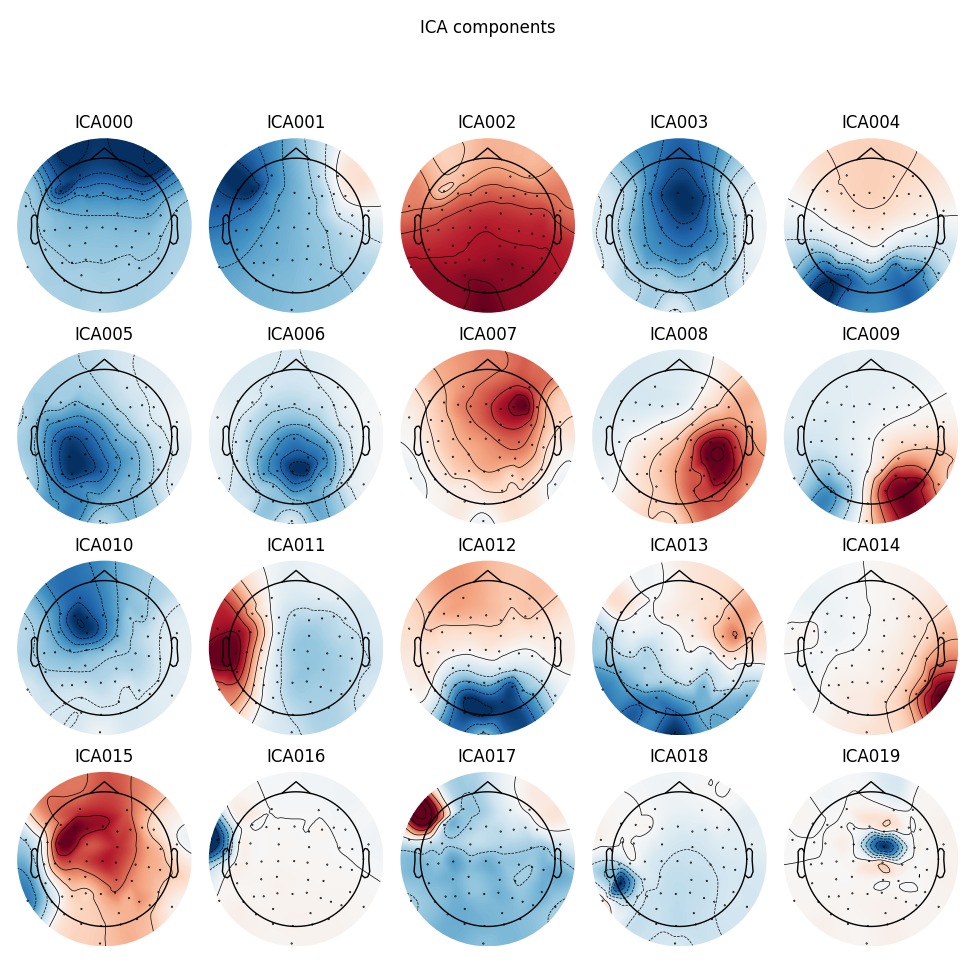

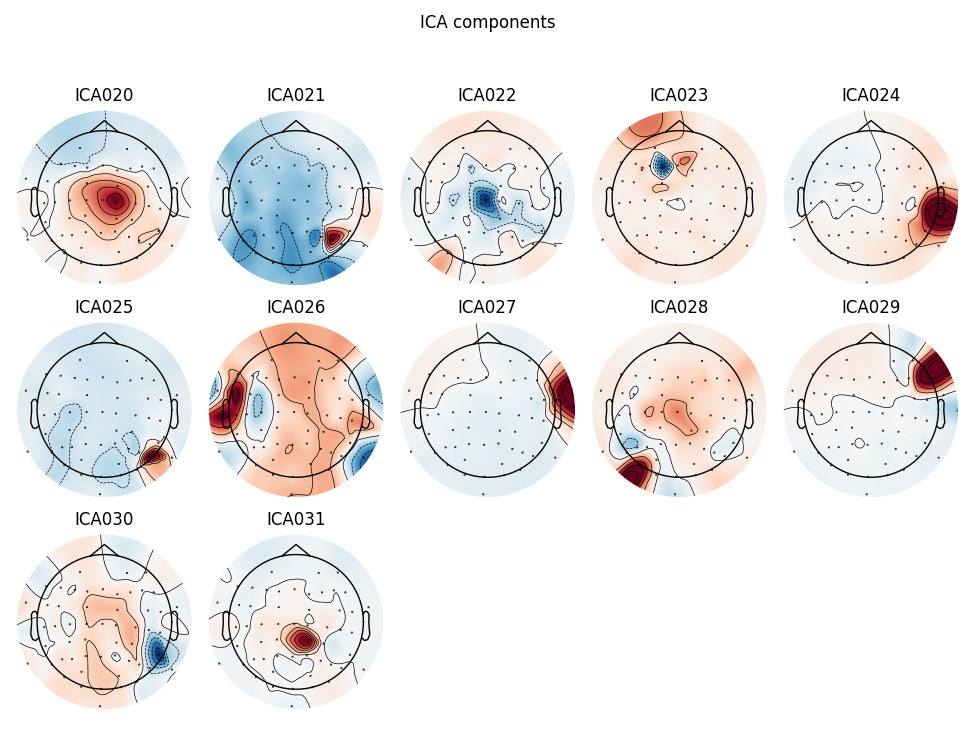

In [5]:
%matplotlib widget
ica.plot_components()
e=0

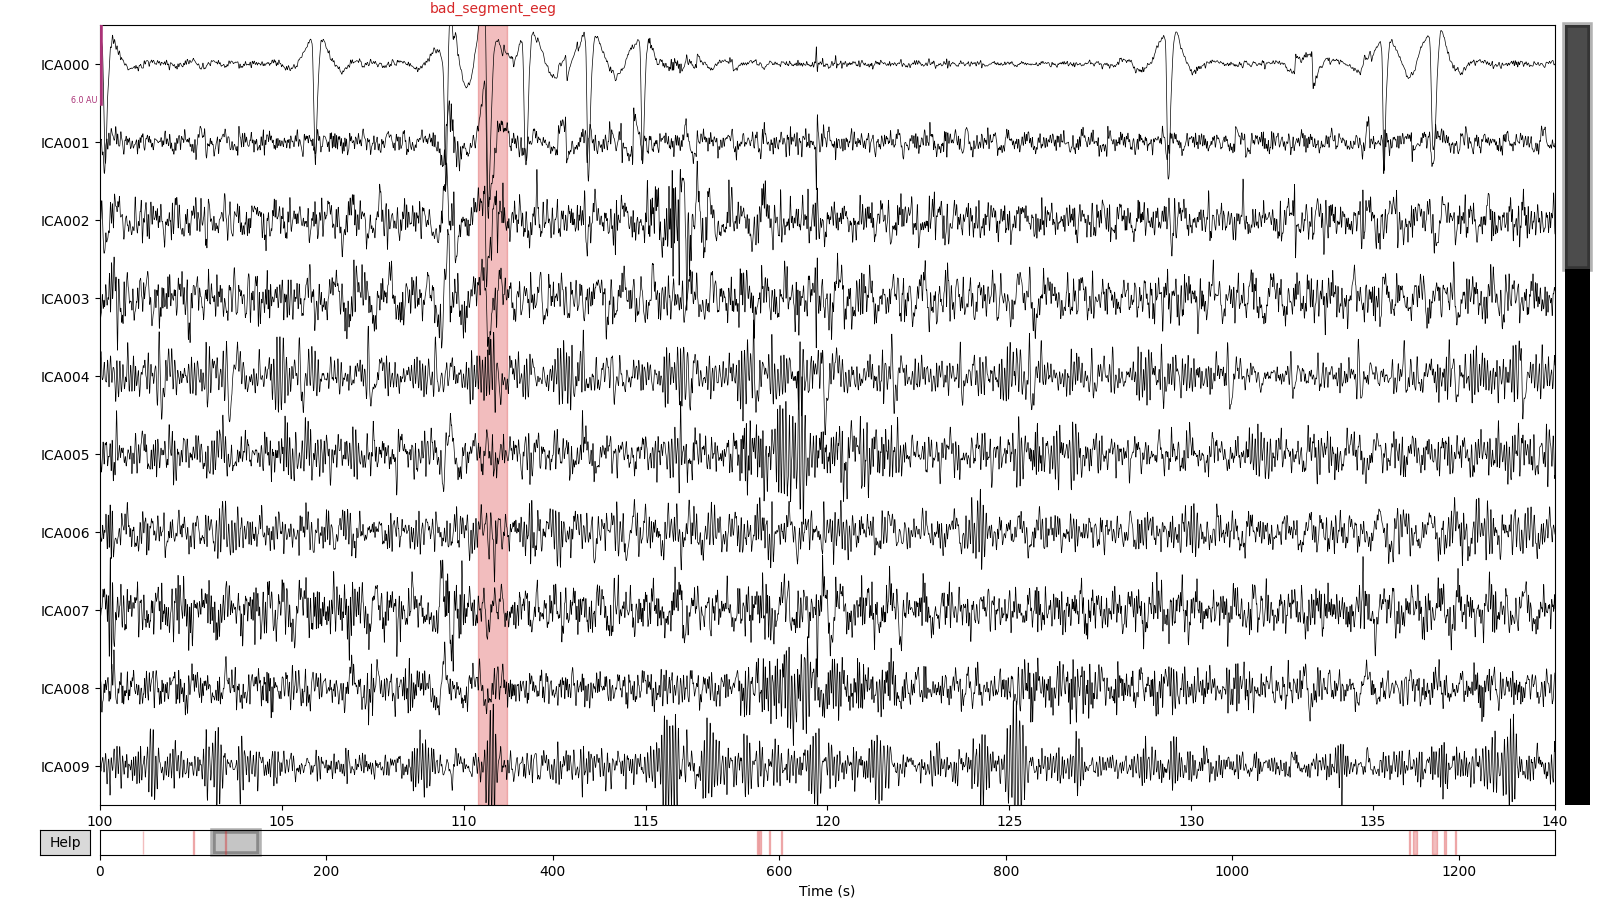

In [6]:
#%matplotlib widget
ica_raw_sources.plot(duration=40, start=100, n_channels=10, scalings=3)
e=0

In [ ]:
%matplotlib widget
plt.plot(ica_sources[16][40000:80000], linewidth=0.5)
e=0

In [8]:
# apply ICA
ica.apply(raw_proc)

<Raw | task_part1_rc_raw_tsss_mc.fif, 398 x 2320000 (2320.0 s), ~6.89 GB, data loaded>

In [9]:
raw_proc = raw_proc.drop_channels(raw_proc.info['bads'])

In [12]:
epochs = mne.Epochs(raw_proc,
                    dataset['events'],
                    event_id=dataset['event_id'],
                    tmin=-0.1,
                    tmax=1.6,
                    baseline=None,
                    picks=['eeg'],
                    reject=None,
                    preload=True)

print(epochs.ch_names)


for epoch, event in zip(epochs, epochs.events):
    data = epoch.T.astype(np.float32)

    event_id = event[-1]
    os.makedirs(f"{outdir}/cond{event_id-2}", exist_ok=True)
    n_trials = int(len(os.listdir(f"{outdir}/cond{event_id-2}")))
    np.save(f"{outdir}/cond{event_id-2}/trial{n_trials}.npy", data)

['EEG005', 'EEG006', 'EEG007', 'EEG008', 'EEG009', 'EEG010', 'EEG011', 'EEG012', 'EEG013', 'EEG014', 'EEG015', 'EEG016', 'EEG017', 'EEG018', 'EEG019', 'EEG020', 'EEG021', 'EEG022', 'EEG023', 'EEG024', 'EEG026', 'EEG027', 'EEG028', 'EEG029', 'EEG030', 'EEG031', 'EEG032', 'EEG033', 'EEG034', 'EEG036', 'EEG037', 'EEG038', 'EEG039', 'EEG040', 'EEG041', 'EEG042', 'EEG043', 'EEG044', 'EEG045', 'EEG046', 'EEG047', 'EEG048', 'EEG049', 'EEG050', 'EEG051', 'EEG052', 'EEG053', 'EEG054', 'EEG055', 'EEG056', 'EEG057', 'EEG058', 'EEG059', 'EEG060']


In [11]:
len(epochs.ch_names)

54

In [43]:
fif_name = "task3_preproc_preproc_raw.fif"
base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
dataset_path = base + f"cross_nocross/preproc1_40hz/oslpy/" + fif_name

# save raw data
raw_proc.save(dataset_path, overwrite=True)

# save ica
fif_name = 'task3_preproc_ica.fif'
dataset_path = base + f"cross_nocross/preproc1_40hz/oslpy/" + fif_name
ica.save(dataset_path, overwrite=True)

Method,fastica
Fit,65 iterations on raw data (1580400 samples)
ICA components,32
Available PCA components,57
Channel types,eeg
ICA components marked for exclusion,ICA000ICA004


In [ ]:
fif_name = "preproc_preproc_raw.fif"
base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/"
dataset_path = base + f"session5/preproc0.2_30hz/oslpy/" + fif_name

In [ ]:
raw_proc = mne.io.read_raw_fif(dataset_path, preload=True)

In [ ]:
%matplotlib widget
raw.plot(n_channels=30, duration=100)
e=0

In [ ]:
%matplotlib widget
raw_proc.plot(n_channels=30, duration=5)
e=0

In [ ]:

base = "/gpfs2/well/woolrich/projects/disp_csaky/eeg/session5/task.cdt"

In [ ]:
raw = mne.io.read_raw_curry(base, preload=True)

In [ ]:
%matplotlib widget
raw_proc.plot_psd(fmax=40, n_fft=10000)
e=0